In [21]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 1000
dt = 0.02
c = 0.7      # CLF rate
alpha = 1.0   # CBF rate
delta_relaxation = 3.0

# Obstacle parameters
ox, oy, r = 2.5, 2.5, 1.0

def make_sdf(x, y):
    dx = x - ox
    dy = y - oy
    return np.sqrt(dx**2 + dy**2) - r

def grad_sdf(x, y):
    norm = np.sqrt((x - ox)**2 + (y - oy)**2)
    return np.array([(x - ox) / norm, (y - oy) / norm])

# Initial state
x, y, theta = 5.2, 5.0, -np.pi * 3 /4
xs, ys, thetas = [x], [y], [theta]
us = []

for i in range(N):
    c = 0.7 * (1 + i * 1.0 / 1000.0)
    # Control input
    u = cp.Variable(3)

    x_dot_bl = u[0]
    y_dot_bl = 0.0
    if len(us) != 0:
        y_dot_bl = 0.5 * dt * (us[-1][0]*u[1] + us[-1][1] * u[0])
    x_dot = np.cos(theta) * x_dot_bl - np.sin(theta) * y_dot_bl
    y_dot = np.sin(theta) * x_dot_bl + np.cos(theta) * y_dot_bl

    # CLF constraint
    V = 0.5 * (x**2 + y**2)
    V_dot = x * x_dot + y * y_dot
    clf_constraint = V_dot + c * V <= u[2] #delta_relaxation

    # CBF constraint
    h = make_sdf(x, y)
    grad_h = grad_sdf(x, y)
    h_dot = grad_h[0] * x_dot + grad_h[1] * y_dot
    cbf_constraint = h_dot + alpha * h >= 0

    # cap1 = u[0]**2 <= 4.0

    # Optimization problem
    cost = u[0]**2 + 0.05 * u[1]**2 + delta_relaxation * u[2]**2
    prob = cp.Problem(cp.Minimize(cost), [clf_constraint, cbf_constraint])
    prob.solve()

    # Apply control
    u_val = u.value
    us.append(u_val)
    x += u_val[0] * np.cos(theta) * dt
    y += u_val[0] * np.sin(theta) * dt
    theta += u_val[1] * dt
    xs.append(x)
    ys.append(y)
    thetas.append(theta)

# Plot the trajectory
xs = np.array(xs)
ys = np.array(ys)

circle = plt.Circle((ox, oy), r, color='r', alpha=0.3, label='Obstacle')

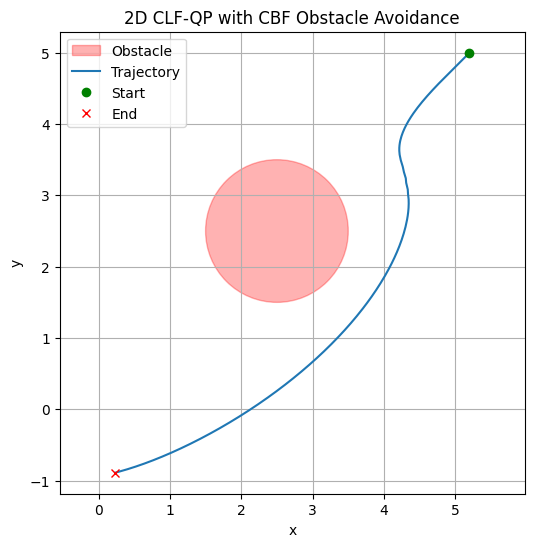

In [22]:
plt.figure(figsize=(6, 6))
plt.gca().add_patch(circle)
plt.plot(xs, ys, markersize=3, label="Trajectory")
plt.plot(xs[0], ys[0], 'go', label='Start')
plt.plot(xs[-1], ys[-1], 'rx', label='End')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D CLF-QP with CBF Obstacle Avoidance')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

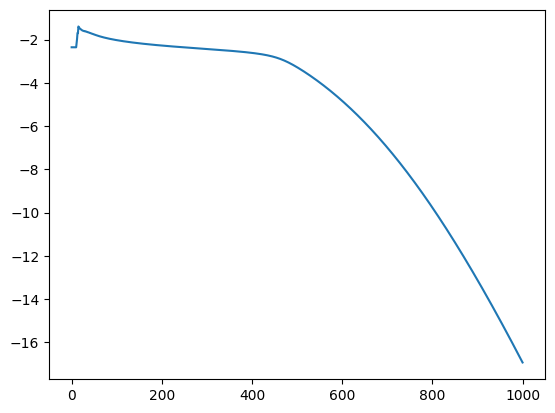

In [6]:
plt.plot(thetas)